<a href="https://colab.research.google.com/github/eyobshittuu/project-1-gym-and-fitness/blob/main/Potato_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Potato Disease Classification
Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<b>Importing dependencies</b>

In [17]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

<b>Set all the Constants</b>

In [18]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS =3
EPOCHS = 10

<b>Import data into tensorflow dataset object</b>

We will use image_dataset_from_directory api to load all images in tensorflow dataset:
 https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [19]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [20]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [21]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 0 1 0 1 1 0 1 0 2 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

<b>Visualize some of the images from our dataset</b>

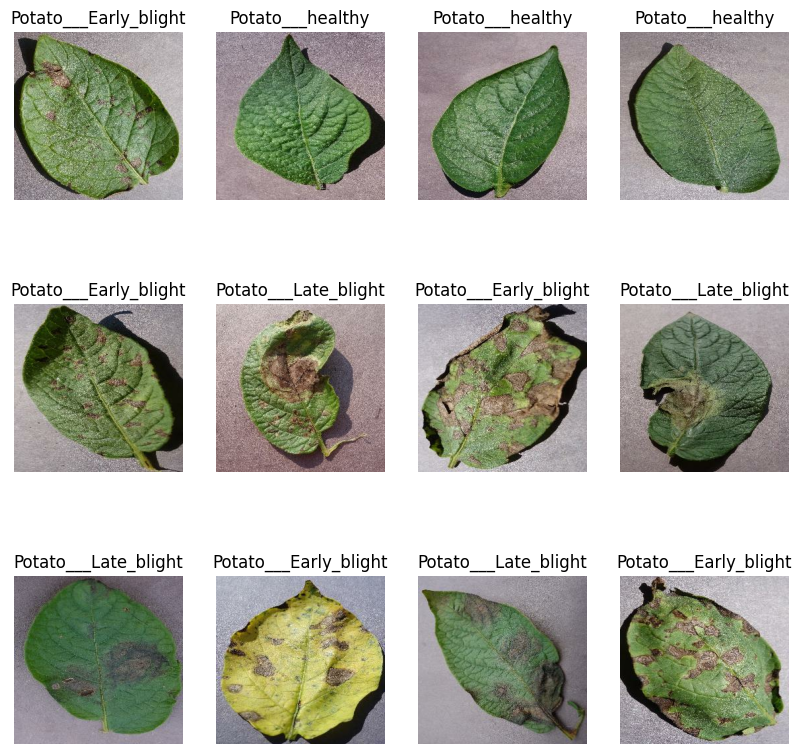

In [22]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,1+i)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

<b><h>Function to Split Dataset</h></b>

Dataset should be bifurcated into 3 subsets, namely:



1.   Training: Dataset to be used while training.
2.   Validation: Dataset to be tested against while training
3.   Test: Dataset to be tested against after we trained a model




In [23]:
len(dataset)

68

In [24]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [25]:
train_ds = dataset.take(54)
len(train_ds)

54

In [26]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [27]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [28]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [29]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [30]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  assert  (train_split + test_split + val_split) == 1

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [31]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [32]:
len(train_ds)

54

In [33]:
len(val_ds)

6

In [34]:
len(test_ds)

8

<b>Cache, Shuffle, and Prefetch the Dataset</b>

In [35]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

## Building the Model

**Creating a Layer for Resizing and Normalization**

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [36]:
import tensorflow as tf
from tensorflow.keras import layers


resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Use layers.Resizing directly
    layers.Rescaling(1./255)  # Use layers.Rescaling directly
])

# Data Augmentation


Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [37]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Updated to use layers.RandomFlip
    layers.RandomRotation(0.2),  # Updated to use layers.RandomRotation
])

<b>Applying Data Augmentation to Train Dataset</b>

In [38]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [39]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

# Apply resize_and_rescale as a preprocessing step outside the model definition
def preprocess_input(image, label):
    image = resize_and_rescale(image)  # Assuming resize_and_rescale is a callable function
    return image, label

train_ds = train_ds.map(preprocess_input).prefetch(buffer_size=tf.data.AUTOTUNE)


model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),  # Define input_shape here
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) # Build with batch size as None

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [41]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [45]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 335s 4s/step - accuracy: 0.4305 - loss: 0.9663 - val_accuracy: 0.4531 - val_loss: 34.7205
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step - accuracy: 0.5884 - loss: 0.8224 - val_accuracy: 0.4531 - val_loss: 489.4344
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.7286 - loss: 0.6364 - val_accuracy: 0.4740 - val_loss: 421.1635
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.8082 - loss: 0.4319 - val_accuracy: 0.5781 - val_loss: 384.5377
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 258s 4s/step - accuracy: 0.8386 - loss: 0.3703 - val_accuracy: 0.4740 - val_loss: 996.3625
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - accuracy: 0.8693 - loss: 0.3177 - val_accuracy: 0.5833 - val_loss: 530.6619
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 217s 4s/step - accuracy: 0.8965 - loss: 0.2681 - val_accuracy: 0.6042 - val_loss: 493.7549
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 219s 4s/step - accuracy: 0.9281 - loss: 0.1778 - val_accurac

<b>You can see above that we get 95.70% accuracy for our test dataset. This is considered to be a pretty good accuracy

In [49]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 982ms/step - accuracy: 0.7035 - loss: 282.4095


<b>Scores is just a list containing loss and accuracy value

In [50]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [52]:
# Assuming 'model' is your defined Keras model
#  Import necessary libraries
from sklearn.model_selection import train_test_split
# Load or create your training data and labels - Replace with your actual data loading/creation code
# For example, if you are using a dataset from scikit-learn:
from sklearn.datasets import load_iris
iris = load_iris

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [53]:
type(history.history['loss'])

list

In [54]:
len(history.history['loss'])

10

In [55]:
history.history['loss'][:5]

[0.9180029630661011,
 0.7245215773582458,
 0.5601493120193481,
 0.41095882654190063,
 0.37203729152679443]

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

## Run prediction on a sample image

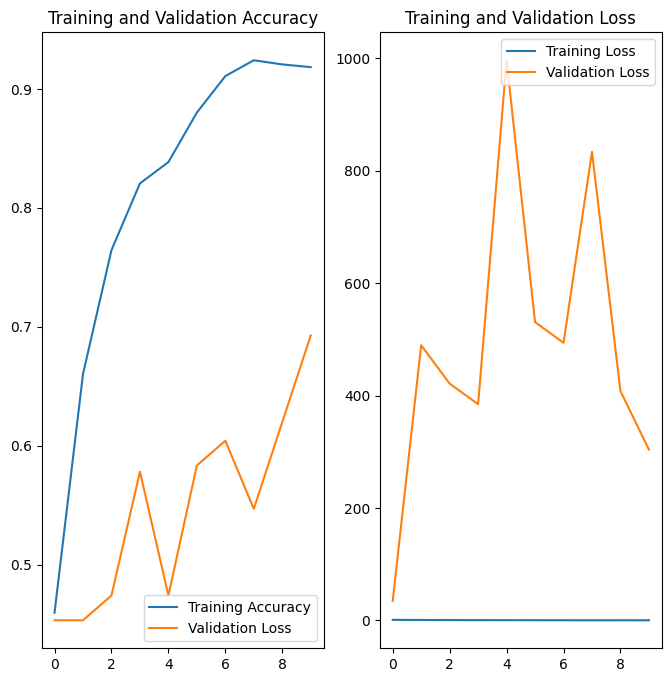

In [57]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
predicted label: Potato___Late_blight


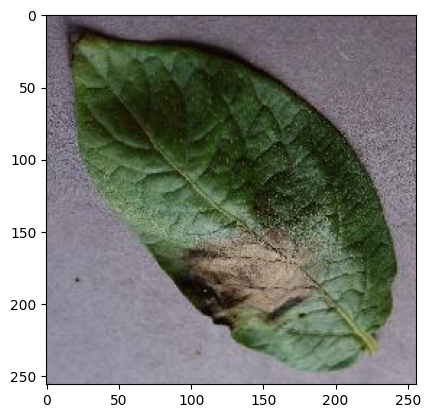

In [58]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label:", class_names[np.argmax(batch_prediction[0])])

## Write a function for inference

In [59]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## Now run inference on few sample images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


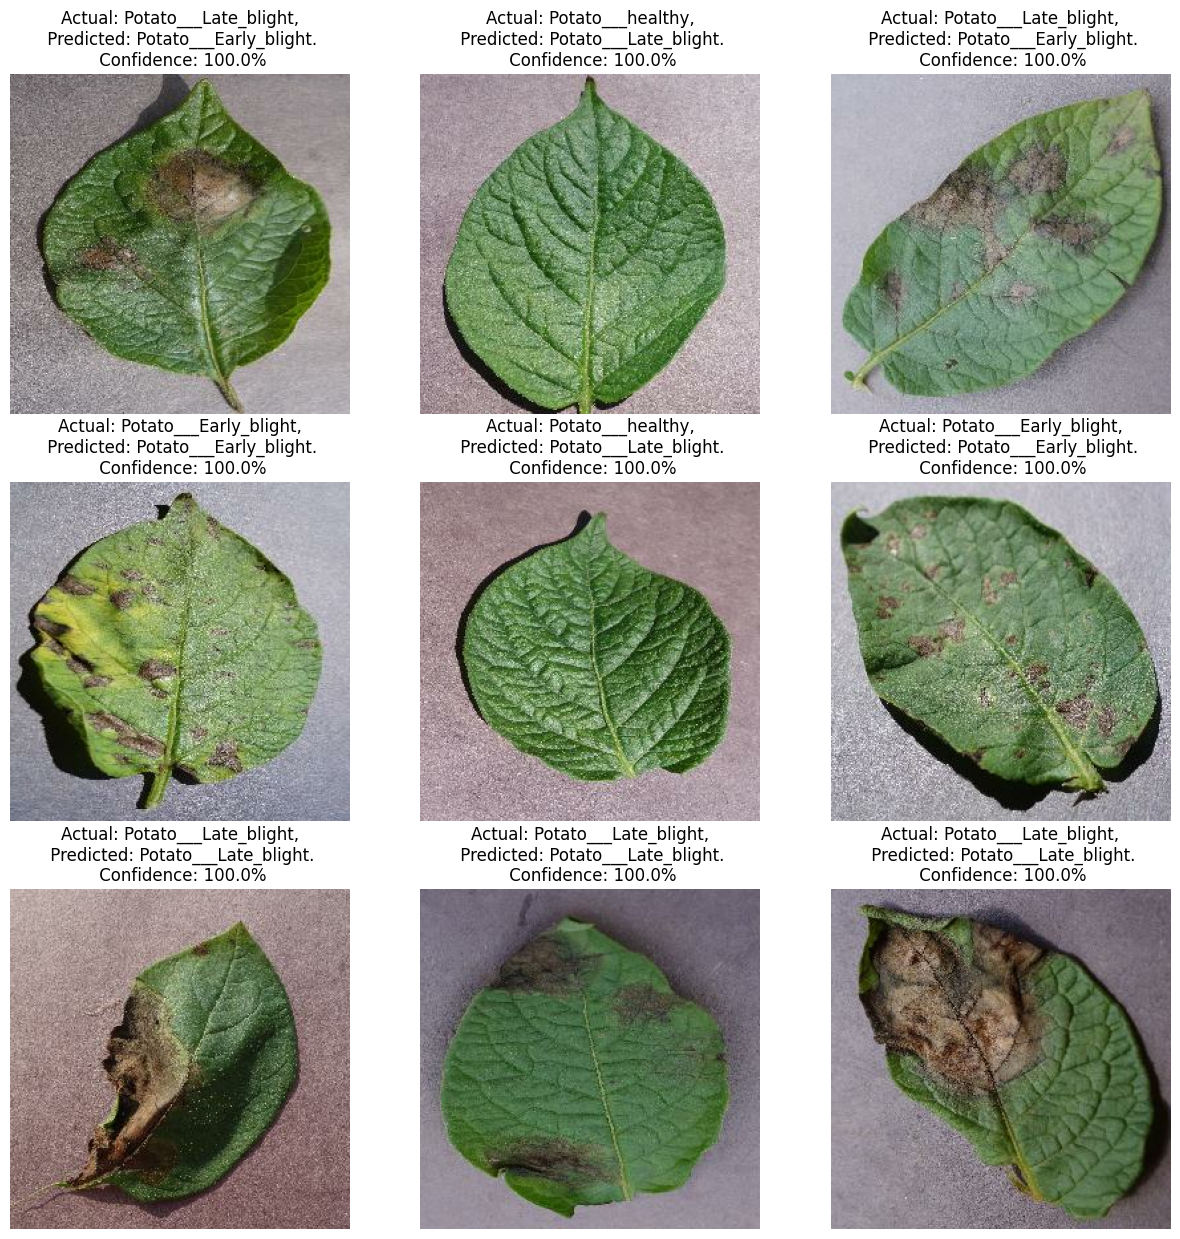

In [60]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")